In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import silhouette_score

you have to figure out how you can use the work iarantsoa did in this file + change this:<br>
user_style_matrix_scaled<br>
to adapt to what she has

In [5]:
df = pd.read_csv('../../knnData/BA_US_knn_text.csv')

              Feature  Importance
0                 abv    0.294771
7  encoded_beer_style    0.242204
6              rating    0.127479
1          appearance    0.088062
2               aroma    0.083075
5             overall    0.060770
3              palate    0.055684
4               taste    0.047954


/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_41367/2653336084.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')


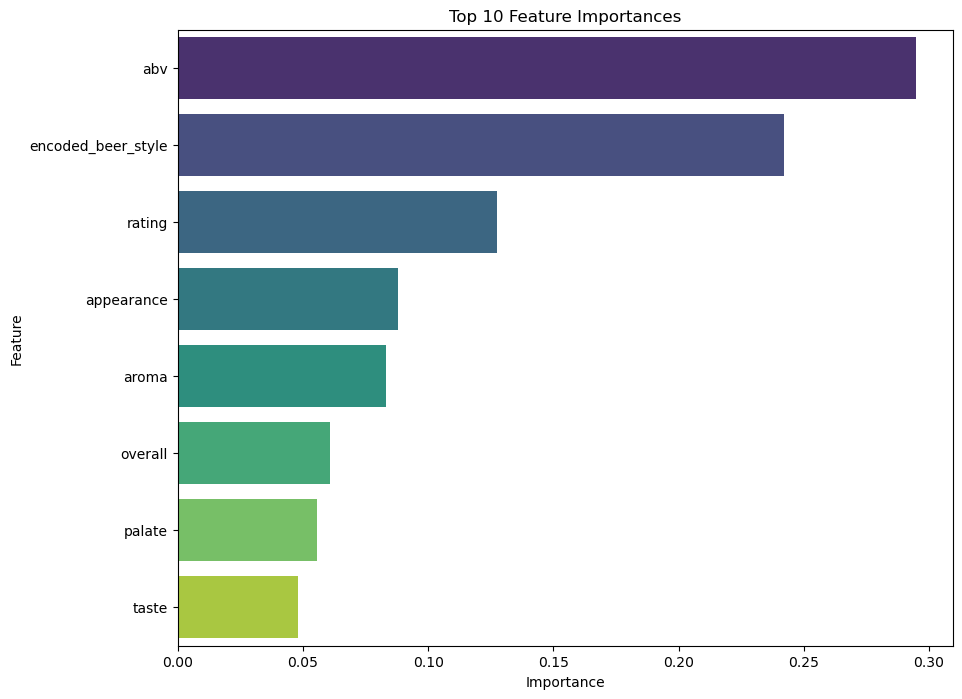

In [6]:
%run param_selec.ipynb

You are using iterative imputation, which predicts the missing values based on the other features (see param_selec.ipynb => there are ~2.7 million Nan values in certain columns)<br>


/opt/anaconda3/envs/ada/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


abv                   0
appearance            0
aroma                 0
palate                0
taste                 0
overall               0
rating                0
encoded_beer_style    0
dtype: int64


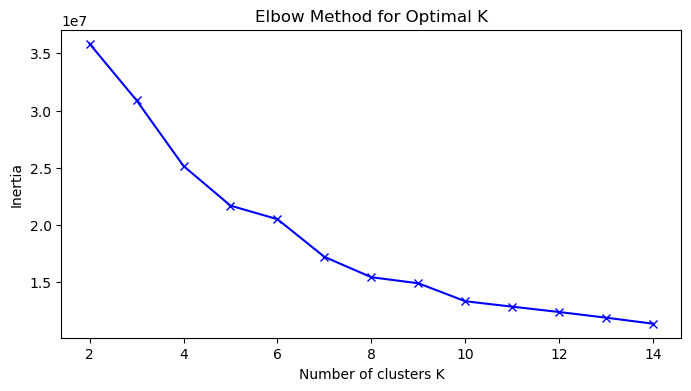

In [12]:
iter_imputer = IterativeImputer(random_state=42)
X_iter_imputed = pd.DataFrame(iter_imputer.fit_transform(X), columns=X.columns)

print(X_iter_imputed.isnull().sum())

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_iter_imputed), columns=X_iter_imputed.columns)

inertia = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
X_scaled['cluster'] = cluster_labels

silhouette_avg = silhouette_score(X_scaled.drop('cluster', axis=1), cluster_labels)
print(f'Silhouette Score for K={optimal_k}: {silhouette_avg}')

You want to look for the "elbow" point in the inertia plot (how close the points are to their center of cluster) => you pick starting that point<br>
=> us around 5 or 6

In [16]:
df.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,user_id,appearance,aroma,palate,taste,overall,rating,text,avg,user_state,beer_state
0,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,4.4,n2185.211743,2.50,4.00,4.00,3.75,3.75,3.76,NaN,3.76,North Carolina,Wisconsin
1,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,4.6,n2185.211743,3.00,3.75,4.00,3.50,3.50,3.58,NaN,3.58,North Carolina,Wisconsin
2,One Cent Wheat,289319.0,Copper State Brewing Company,49595.0,Witbier,5.4,n2185.211743,3.75,3.25,3.75,3.50,3.50,3.48,NaN,3.48,North Carolina,Wisconsin
3,Platinum Coffee Blonde,289324.0,Copper State Brewing Company,49595.0,American Blonde Ale,7.3,n2185.211743,3.25,3.75,3.50,4.25,4.25,4.00,NaN,4.02,North Carolina,Wisconsin
4,Platinum Coffee Blonde,289324.0,Copper State Brewing Company,49595.0,American Blonde Ale,7.3,angerhaus.1049226,4.00,4.25,3.75,4.00,4.00,4.04,NaN,4.02,Wisconsin,Wisconsin


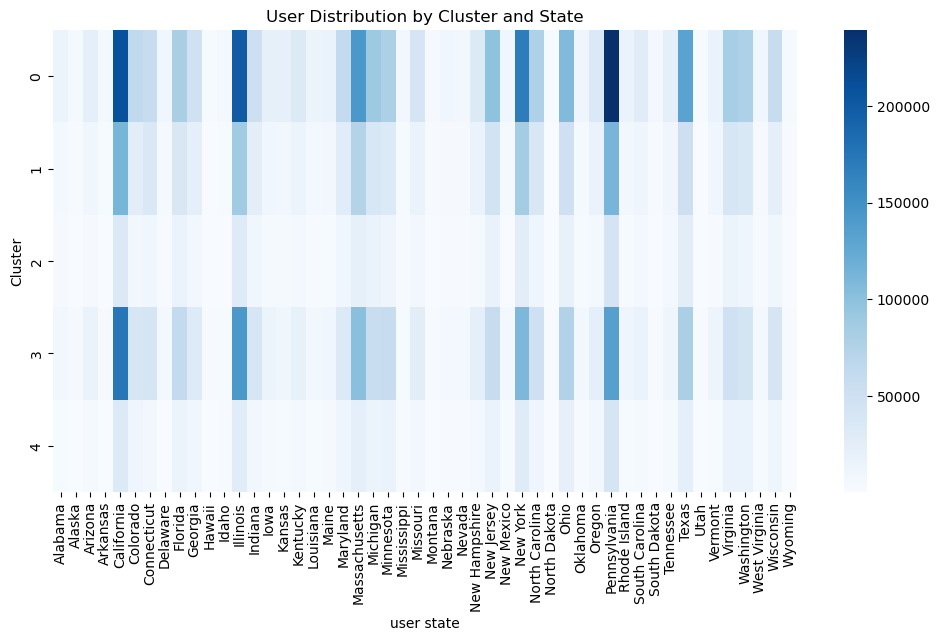

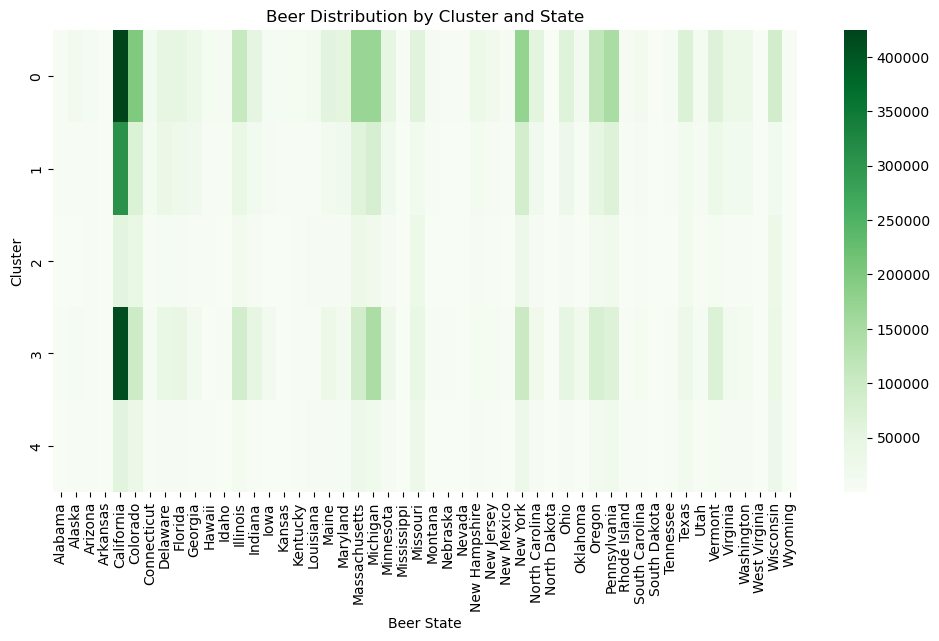

In [19]:
cluster_labels_df = X_scaled[['cluster']].reset_index(drop=True)
cluster_labels_df['user_id'] = df['user_id'].values
cluster_labels_df['beer_id'] = df['beer_id'].values

cluster_labels_df = cluster_labels_df.merge(
    df[['user_id', 'user_state']].drop_duplicates(),
    on='user_id',
    how='left'
)

if 'beer_id' in df.columns:
    cluster_labels_df = cluster_labels_df.merge(
        df[['beer_id', 'beer_state']].drop_duplicates(),
        on='beer_id',
        how='left'
    )

user_cluster_state_counts = cluster_labels_df.groupby(['cluster', 'user_state']).size().unstack(fill_value=0)

if 'beer_state' in cluster_labels_df.columns:
    beer_cluster_state_counts = cluster_labels_df.groupby(['cluster', 'beer_state']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(user_cluster_state_counts, annot=False, fmt='d', cmap='Blues')
plt.title('User Distribution by Cluster and State')
plt.xlabel('user state')
plt.ylabel('Cluster')
plt.show()

if 'beer_state' in cluster_labels_df.columns:
    plt.figure(figsize=(12, 6))
    sns.heatmap(beer_cluster_state_counts, annot=False, fmt='d', cmap='Greens')
    plt.title('Beer Distribution by Cluster and State')
    plt.xlabel('Beer State')
    plt.ylabel('Cluster')
    plt.show()
